# The diffusion constant

In this notebook we'll measure the diffusion constant by looking at the mean squared displacement of every atom in an Argon gas. That is, we compute the mean squared displacement from
\begin{align}
    \langle r^2(t) \rangle
    = \frac{1}{N} \sum_{i = 1}^{N} \left(
        \mathbf{r}_i(t) - \mathbf{r}_i(t_0)
    \right)^2,
\end{align}
where $t_0$ is the time at the start of the simulation. Computing the displacement at every time step can prove hard due to periodic boundary conditions. Luckily, Lammps can compute the quantity for us!

In [50]:
import os
import sys
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)

In [25]:
%%writefile scripts/diffusion.in

# 3d Lennard-Jones gas
units lj
dimension 3
timestep 0.005
# Periodic boundiaries
boundary p p p
atom_style atomic

lattice fcc 0.01
region simbox block 0 10 0 10 0 10
create_box 1 simbox
create_atoms 1 box

mass 1 1.0
velocity all create ${T} 87287

pair_style lj/cut 3.0
pair_coeff 1 1 1.0 1.0 3.0

#fix 1 all nvt temp ${T} ${T} 3.0
fix 1 all nve

thermo 10
run 5000


reset_timestep 0
variable mytime equal dt*step
compute msd all msd
thermo_style custom step temp time v_mytime press ke pe etotal c_msd[4]

log dat/diffusion_${T}.log

run 25000

Overwriting scripts/diffusion.in


In [26]:
%%bash

export OMP_NUM_THREADS=4

for T in $(seq 2 10); do
    mpirun -np 4 lmp -var T $T -in scripts/diffusion.in
done

LAMMPS (4 Jan 2019)
  using 4 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 7.36806 7.36806 7.36806
Created orthogonal box = (0 0 0) to (73.6806 73.6806 73.6806)
  1 by 2 by 2 MPI processor grid
Created 4000 atoms
  Time spent = 0.000946613 secs
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 3.3
  ghost atom cutoff = 3.3
  binsize = 1.65, bins = 45 45 45
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair lj/cut, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d/newton
      bin: standard
Setting up Verlet run ...
  Unit style    : lj
  Current step  : 0
  Time step     : 0.005
Per MPI rank memory allocation (min/avg/max) = 5.859 | 5.859 | 5.859 Mbytes
Step Temp E_pair E_mol TotEng Press 
       0            2            0            0      2.99925     0.019995 
      10            2            0

In [40]:
file_list = list(filter(lambda x: x.startswith("diffusion"), os.listdir("dat")))

pattern = r"diffusion_(.+).log"
temperature_list = [float(re.search(pattern, filename).group(1)) for filename in file_list]

file_list = list(map(lambda x: os.path.join("dat", x), file_list))

temperature_list, file_list = zip(*sorted(zip(temperature_list, file_list)))

In [45]:
log_df = pd.read_csv(file_list[0], sep=r"\s+", skiprows=3, skipfooter=27, engine="python")

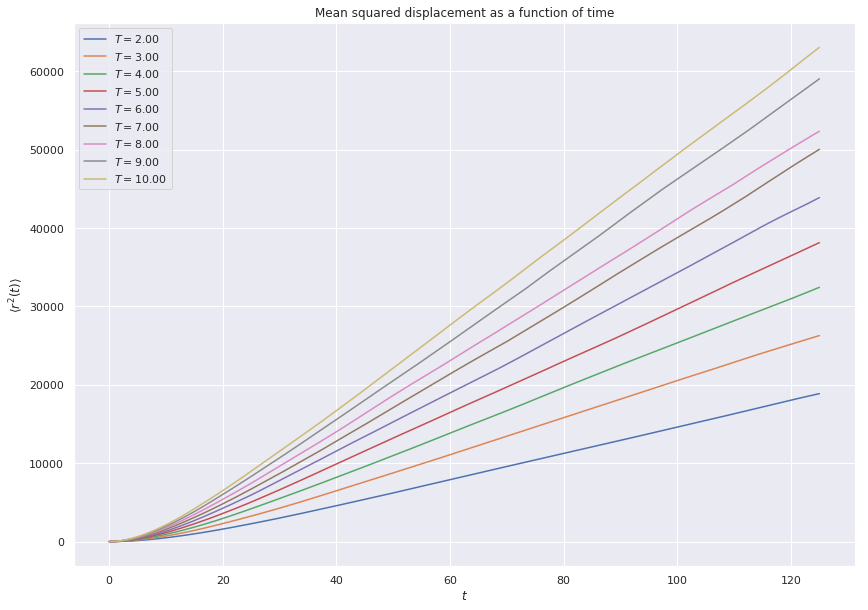

In [55]:
fig = plt.figure(figsize=(14, 10))

for T, filename in zip(temperature_list, file_list):
    log_df = pd.read_csv(filename, sep=r"\s+", skiprows=3, skipfooter=27, engine="python")
    plt.plot(
        log_df["v_mytime"],
        log_df["c_msd[4]"],
        label=fr"$T = {T:.2f}$"
    )

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t)\rangle$")
plt.legend(loc="best")
plt.title(r"Mean squared displacement as a function of time")
plt.show()

In this plot we see the mean squared displacement plotted against time. When $t$ is larger than some threshold $t_t$ we see that the expected linear relationship
\begin{align}
    \langle r^2(t) \rangle = D(T) t,
\end{align}
is achieved. However, when $t$ is close to the initial time $t_0$ we get _anomlous diffusion_, that is, the mean squared displacement is not a linear function of time. As long as $t < t_t$ the mean squared displacement experiences _superdiffusion_, that is,
\begin{align}
    \langle r^2 (t) \rangle \propto t^{\alpha},
\end{align}
where $\alpha > 1$.